In [1]:
import os.path
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.lines import Line2D
from IPython.display import HTML

In [2]:

# Configure matplotlib
plt.style.use("seaborn-paper")
plt.rc("font", family="serif")
PLT_FONT_SIZE = 4.75
plt.rc("font", size=PLT_FONT_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=PLT_FONT_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=PLT_FONT_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=PLT_FONT_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=PLT_FONT_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=PLT_FONT_SIZE)  # legend fontsize
plt.rc("figure", titlesize=PLT_FONT_SIZE)  # fontsize of the figure title
plt.rc("figure", titleweight="bold")
plt.rc("figure", dpi=200)
plt.rc("figure", figsize=[7, 3.5])
#plt.rcParams["animation.html"] = "jshtml"
#plt.rcParams['figure.dpi'] = 150  
#plt.ioff()

In [3]:
# Class to read data files
import numpy as np


class DataReader:
    def __init__(self, file_path):
        self.file_path = file_path
        self.__read()

    def __read(self):
        with open(self.file_path, "r") as file_handle:
            file_lines = list(file_handle.readlines())
            file_handle.close()

            # Convert lines to int or float accordingly
            cleaned_data = []
            for index, line in enumerate(file_lines):
                # indexes <= 1 should be convert to int
                cleaned_data.append(list(map(float, line.split())))

            # Unpack dataset
            (
                self.x,
                self.y,
                self.x_filt,
                self.y_filt,
                self.vel_x,
                self.vel_y,
                self.vel,
                self.acc,
                self.velx_filt,
                self.vely_filt,
                self.vel_filt,
                self.acc_filt,
            ) = cleaned_data

            # Create distances attr, euclidian distance to (0, 0)
            self.distances = []
            for _x, _y in zip(self.x, self.y):
                d = np.sqrt(np.power(_x, 2) + np.power(_y, 2))
                self.distances.append(d)


In [4]:
# Our concept drift detection method
import math


class MarkovChain:
    def __init__(self):
        self.system = {}
        self.current_origin = None
        self.current_destination = None

    def update(self, origin, destination, alpha):
        origin = f"{origin:.2f}"
        destination = f"{destination:.2f}"

        if origin != destination or (
            not self.current_origin and not self.current_destination
        ):
            self.current_origin = origin
            self.current_destination = destination

        if self.current_origin not in self.system:
            self.system[self.current_origin] = {}

        if self.current_destination not in self.system[self.current_origin]:
            self.system[self.current_origin][self.current_destination] = 0.0

        for possible_destination in self.system[self.current_origin]:
            if possible_destination == self.current_destination:
                self.system[self.current_origin][possible_destination] += alpha
                if self.system[self.current_origin][possible_destination] > 1:
                    self.system[self.current_origin][possible_destination] = 1
            else:
                reduction_factor = alpha / (len(self.system[self.current_origin]) - 1)
                self.system[self.current_origin][
                    possible_destination
                ] -= reduction_factor
                if self.system[self.current_origin][possible_destination] < 0:
                    self.system[self.current_origin][possible_destination] = 0

        return self.system[self.current_origin][self.current_destination]


class RBFChain:
    """ Radial Basis Functions - Drift Detection Method.

    Parameters
    ----------
    sigma: float (default=2)
        Delimits the Gaussian radius.

    lambda_: float (default=0.5)
        Minimum threshold.

    alpha: float (default=0.25)
        Value to increase the probability in the Markov Chain.

    delta: float (default=1.0)
        Minimum threshold to consider the probability as a Concept Drift indication.
    """

    def __init__(self, sigma=2, lambda_=0.5, alpha=0.25, delta=1.0):
        self.sigma = sigma
        self.lambda_ = lambda_
        self.alpha = alpha
        self.delta = delta

        self.actual_center = None
        self.centers = []
        self.sample_count = 0

        self.markov = MarkovChain()

        self.reset()

    def reset(self):
        """ reset

        Resets the change detector parameters.

        """
        self.sample_count = 1


    def add_element(self, input_data):
        """ Add a new element to the statistics

        Parameters
        ----------
        prediction: float
        """
        self.sample_count += 1

        activation = 0.0
        activation_lambda = self.lambda_
        distance = 0.0
        activated_center = None

        for center in self.centers:
            distance = math.sqrt(math.pow(input_data - center, 2.0))
            activation = math.exp(-math.pow(self.sigma * distance, 2))

            if activation >= activation_lambda:
                activated_center = center
                activation_lambda = activation

        if not activated_center:
            self.centers.append(input_data)
            activated_center = input_data

        if self.actual_center is None:
            self.actual_center = activated_center

        # Update markov
        probability = self.markov.update(
            self.actual_center, activated_center, self.alpha
        )

        # If probability higher, update actual_center if different
        if probability >= self.delta and self.actual_center != activated_center:
            self.actual_center = activated_center

        return probability


In [5]:
# Tunning: TPE Sampler
RBFCHAIN_KWARGS = {"sigma": 0.001, "lambda_": 0.8, "alpha": 0.1, "delta": 1.0}

In [6]:
import glob
glob.glob("datasets/*.txt")

['datasets/juj004c01-Trial138-Export-Raw.txt',
 'datasets/juj004c01-Trial78-Export-Raw.txt',
 'datasets/juj004c01-Trial35-Export-Raw.txt',
 'datasets/juj004c01-Trial24-Export-Raw.txt',
 'datasets/juj004c01-Trial100-Export-Raw.txt',
 'datasets/juj004c01-Trial97-Export-Raw.txt',
 'datasets/juj004c01-Trial9-Export-Raw.txt',
 'datasets/juj004c01-Trial5-Export-Raw.txt',
 'datasets/juj004c01-Trial108-Export-Raw.txt',
 'datasets/juj004c01-Trial147-Export-Raw.txt',
 'datasets/juj004c01-Trial6-Export-Raw.txt',
 'datasets/juj004c01-Trial112-Export-Raw.txt',
 'datasets/juj004c01-Trial101-Export-Raw.txt',
 'datasets/juj004c01-Trial113-Export-Raw.txt',
 'datasets/juj004c01-Trial115-Export-Raw.txt',
 'datasets/juj004c01-Trial141-Export-Raw.txt',
 'datasets/juj004c01-Trial132-Export-Raw.txt',
 'datasets/juj004c01-Trial75-Export-Raw.txt',
 'datasets/juj004c01-Trial66-Export-Raw.txt',
 'datasets/juj004c01-Trial11-Export-Raw.txt',
 'datasets/ded005a06-Trial24-Export-Raw.txt',
 'datasets/ded005a06-Trial2

In [7]:
# Define the dataset

In [8]:
dataset = 'datasets/juj004c01-Trial120-Export-Raw.txt'

dataset_abs_path = os.path.abspath(dataset)
dataset_filename = os.path.basename(dataset)

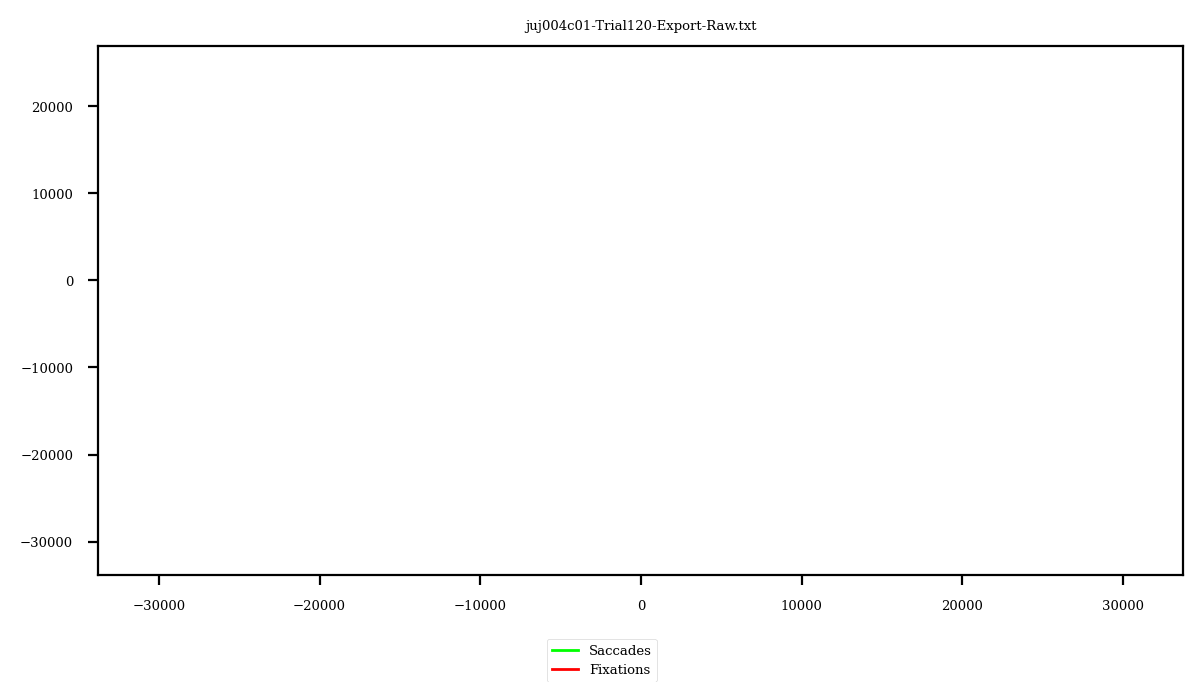

In [9]:
#
# Plot setup
#
fig = plt.figure()
fig.gca().set_title(dataset_filename)

# Plot data
xdata, ydata = [], []
fixations_x, fixations_y = [], []
fixations_times = []

# Lines/Points
(ln,) = plt.plot(xdata, ydata, "-", color=(0, 1, 0), linewidth=0.25)
(fixations,) = plt.plot(
    fixations_x,
    fixations_y,
    linestyle="",
    marker="o",
    markersize=1,
    alpha=0.25,
    color="red",
)

# Legends
custom_legends = [
    Line2D([0], [0], color=(0, 1, 0), ls="-", linewidth=1),
    Line2D([0], [0], color="r", ls="-", linewidth=1),
]
fig.legend(
    custom_legends,
    ["Saccades", "Fixations"],
    ncol=1,
    borderaxespad=0,
    loc="lower center",
)

#
# Processing dataset
#
dataset = DataReader(dataset_abs_path)
rbfchain = RBFChain(**RBFCHAIN_KWARGS)

result_rbfchain_predictions = []
result_rbfchain_fixations_positions = []

for index, input_data in enumerate(dataset.distances):
    probability = rbfchain.add_element(input_data)

    is_fixation = probability >= rbfchain.delta

    if is_fixation:
        result_rbfchain_predictions.append(1)
        result_rbfchain_fixations_positions.append(index)
    else:
        result_rbfchain_predictions.append(0)

#
# Animation functions
#
def init():
    fig.gca().set_xlim((min(dataset.x) - 1000, max(dataset.x) + 1000))
    fig.gca().set_ylim((min(dataset.y) - 1000, max(dataset.y) + 1000))
    return (ln,)


def handle(frame_index):
    xdata.append(dataset.x[frame_index])
    ydata.append(dataset.y[frame_index])
    ln.set_data(xdata, ydata)

    if result_rbfchain_predictions[frame_index]:
        fixations_x.append(dataset.x[frame_index])
        fixations_y.append(dataset.y[frame_index])
        fixations.set_data(fixations_x, fixations_y)

    return (ln, fixations)


#
# Start animation
#
animation = FuncAnimation(
    fig,
    handle,
    frames=len(dataset.x),
    init_func=init,
    interval=0.1,
    blit=True,
    repeat=True,
)

In [11]:
HTML(animation.to_html5_video())